In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
transform=transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

In [99]:
class SampleDataset(Dataset):
    def __init__(self, image_dir, conductivities, sp_vols, transform=None):
        self.conds=conductivities
        self.sp_vols=sp_vols
        self.samples=[]
        for filename in sorted(os.listdir(image_dir), key=lambda x: int(x[:-5])):
            self.samples.append(transform(Image.open(image_dir+filename)))
        self.samples=torch.stack(tensors=self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index], self.sp_vols[index], self.conds[index]
    
    def to(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)
        self.sp_vols=self.sp_vols.to(device)

In [100]:
with open('./data/data.csv') as f:
    reader=csv.reader(f)
    d=list(reader)
conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
volPer=torch.tensor(data=[float(x[1]) for x in d[1:]], dtype=torch.float32)
conductivities
dataset=SampleDataset('./data/samples/', conductivities, volPer, transform)
dataset.to('cuda')

In [150]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_filters, image_size):
        super(CNN, self).__init__()

        # calculating image resolution as we progress through model
        image_size_1=(image_size-8+1)//2
        image_size_2=(image_size_1-4+1)//2

        self.conv=torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(8, 8), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=(4, 4), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters*2),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        hidden_layer_size=10

        self.mlp=nn.Sequential(
            nn.Linear(in_features=1, out_features=hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        self.fc=torch.nn.Sequential(
            nn.Linear(in_features=image_size_2*image_size_2*num_filters*2+hidden_layer_size, out_features=150),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=150, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, image, sf_vol_frac):
        conv_output=self.conv(image)
        mlp_output=self.mlp(sf_vol_frac.unsqueeze(1))
        return self.fc(torch.cat([conv_output, mlp_output], dim=1))


In [151]:
model=CNN(1, 32, 160).to('cuda')
torch.cat([torch.tensor([1,2,3,4]), torch.tensor([1,2,3,4,5])], dim=0)

tensor([1, 2, 3, 4, 1, 2, 3, 4, 5])

In [152]:
train_dataset, test_dataset=torch.utils.data.random_split(dataset=dataset, lengths=[0.8, 0.2])
len(train_dataset), len(test_dataset)

(2272, 567)

In [153]:
def train_CNN(train_data, model, loss_fn, optimizer, epochs):
    train_data, val_data=torch.utils.data.random_split(train_data, [0.8, 0.2])
    best_loss=2**63
    val_loss_history=[]
    train_loss_history=[]
    for epoch in range(epochs):
        dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
        running_loss=0
        for batch in dataloader:
            inputs, vols, labels=batch
            optimizer.zero_grad()
            pred=model(inputs, vols)
            loss=loss_fn(pred, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

        with torch.no_grad():
            val_dataloader=DataLoader(val_data)
            val_loss=0
            for batch in val_dataloader:
                inputs, vols, labels=batch
                pred=model(inputs, vols)
                loss=loss_fn(pred, labels.unsqueeze(1))
                val_loss+=loss.item()
            print(epoch, 'TRAINING LOSS:', running_loss/len(dataloader), 'VALIDATION LOSS:', val_loss/len(val_dataloader))
            val_loss_history.append(val_loss/len(val_dataloader))
            train_loss_history.append(running_loss/len(dataloader))
       
        if best_loss>running_loss/len(dataloader):
            best_loss=running_loss/len(dataloader)
            torch.save(model.state_dict(), "CNN_BEST1.pt")
    return val_loss_history, train_loss_history

In [154]:
val_loss_history, train_loss_history=[],[]

In [252]:
for i in range(10):
    val_loss, train_loss=train_CNN(train_dataset, model, torch.nn.SmoothL1Loss(), torch.optim.Adam(model.parameters(), lr=0.001), 150)
    val_loss_history+=val_loss
    train_loss_history+=train_loss

0 TRAINING LOSS: 5.794804945636363e-05 VALIDATION LOSS: 0.00414341900995057
1 TRAINING LOSS: 1.561419683862927e-05 VALIDATION LOSS: 0.004204013845318294
2 TRAINING LOSS: 1.5667567926389064e-05 VALIDATION LOSS: 0.004290637503976858
3 TRAINING LOSS: 1.3875884840736194e-05 VALIDATION LOSS: 0.004344072156051357
4 TRAINING LOSS: 1.657004140485553e-05 VALIDATION LOSS: 0.004306117458394647
5 TRAINING LOSS: 1.4941236338672114e-05 VALIDATION LOSS: 0.00425923327708809
6 TRAINING LOSS: 1.4970595118843208e-05 VALIDATION LOSS: 0.0044939201247675776
7 TRAINING LOSS: 1.417155876001823e-05 VALIDATION LOSS: 0.004354597686020804
8 TRAINING LOSS: 2.711627353403999e-05 VALIDATION LOSS: 0.004194487070615022
9 TRAINING LOSS: 1.2560435798628819e-05 VALIDATION LOSS: 0.00428223511670974
10 TRAINING LOSS: 3.5123901437927676e-05 VALIDATION LOSS: 0.004016823554208703
11 TRAINING LOSS: 2.4020079715563425e-05 VALIDATION LOSS: 0.004570095724165339
12 TRAINING LOSS: 1.0711235194991642e-05 VALIDATION LOSS: 0.004381072

KeyboardInterrupt: 

In [12]:
transfer_model=tv.models.resnet18(pretrained=True)
transfer_model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
transfer_model.fc=nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 150),  
    nn.ReLU(),                             
    # nn.Dropout(0.3),                       
    nn.Linear(150, 84),
    nn.ReLU(inplace=True),
    # nn.Dropout(p=0.5),
    nn.Linear(in_features=84, out_features=1),
)

for param in transfer_model.parameters():
    param.requires_grad = False

for param in transfer_model.fc.parameters():
    param.requires_grad = True

transfer_model=transfer_model.to('cuda')

In [14]:
val_loss, train_loss=train_CNN(train_dataset, transfer_model, torch.nn.MSELoss(), torch.optim.Adam(transfer_model.parameters(), lr=0.001, weight_decay=1e-5), 1000)

0 TRAINING LOSS: 0.17628619110300428 VALIDATION LOSS: 0.033518038830511444
1 TRAINING LOSS: 0.03376701367752893 VALIDATION LOSS: 0.021188731213153848
2 TRAINING LOSS: 0.025269639101766404 VALIDATION LOSS: 0.0237267811522465
3 TRAINING LOSS: 0.021101762318894976 VALIDATION LOSS: 0.025230320947333587
4 TRAINING LOSS: 0.01676803215273789 VALIDATION LOSS: 0.020686740271270033
5 TRAINING LOSS: 0.015736441793186322 VALIDATION LOSS: 0.022663654397688776
6 TRAINING LOSS: 0.012692155759958993 VALIDATION LOSS: 0.030932261168869643
7 TRAINING LOSS: 0.01616014309582256 VALIDATION LOSS: 0.020586330659683558
8 TRAINING LOSS: 0.010728675384251844 VALIDATION LOSS: 0.02015175249826692
9 TRAINING LOSS: 0.011649307750520251 VALIDATION LOSS: 0.025063851510318255
10 TRAINING LOSS: 0.009779824720074734 VALIDATION LOSS: 0.02004786845220512
11 TRAINING LOSS: 0.008345693815499544 VALIDATION LOSS: 0.020057042890592132
12 TRAINING LOSS: 0.008313720868456932 VALIDATION LOSS: 0.020829305678491006
13 TRAINING LOSS:

ValueError: too many values to unpack (expected 2)

No Regularization with SmoothL1Loss


(0.0, 0.01)

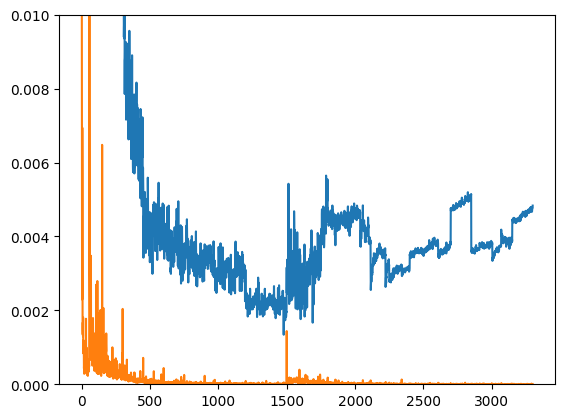

In [253]:
print('No Regularization with SmoothL1Loss')
plt.plot(range(1,len(val_loss_history)), val_loss_history[1:])
plt.plot(range(1,len(train_loss_history)), train_loss_history[1:])
ax=plt.gca()
ax.set_ylim([0, 0.01])

No regularization


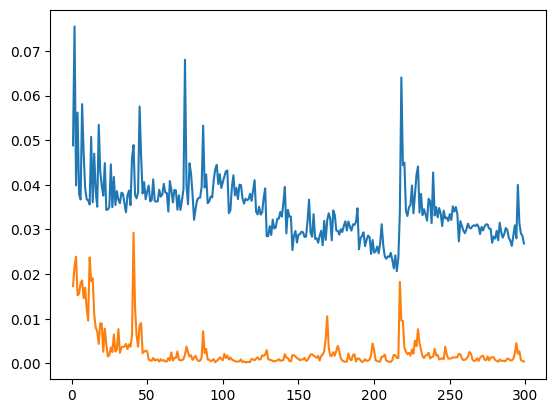

In [ ]:
print('No regularization MSELoss')
plt.plot(range(1,300), val_loss[1:])
plt.plot(range(1,300), train_loss[1:])

In [255]:
with torch.no_grad():
    pred=model(test_dataset[:][0], test_dataset[:][1])
    actual=test_dataset[:][2].unsqueeze(1)
for i in range(len(test_dataset)):
    print(pred[i].item(), actual[i].item(), pred[i].item()-actual[i].item())
print(nn.MSELoss()(pred, actual).item())

1.2530790567398071 1.257513403892517 -0.004434347152709961
1.065990924835205 1.0594372749328613 0.00655364990234375
1.4731450080871582 1.4895583391189575 -0.016413331031799316
1.0978225469589233 1.0959504842758179 0.0018720626831054688
1.4104413986206055 1.4151331186294556 -0.004691720008850098
1.44578218460083 1.4394958019256592 0.0062863826751708984
1.4820935726165771 1.4963685274124146 -0.014274954795837402
1.5177725553512573 1.5061955451965332 0.011577010154724121
1.419769525527954 1.4264863729476929 -0.0067168474197387695
1.4273561239242554 1.4149093627929688 0.012446761131286621
1.0197391510009766 1.0323381423950195 -0.012598991394042969
1.2850288152694702 1.285935878753662 -0.0009070634841918945
1.3929002285003662 1.4096421003341675 -0.01674187183380127
1.328506588935852 1.3357497453689575 -0.007243156433105469
1.118440866470337 1.1197402477264404 -0.0012993812561035156
0.9560866951942444 0.9360983967781067 0.019988298416137695
1.4492071866989136 1.4569534063339233 -0.0077462196

In [41]:
load_model=CNN(1, 32, 160)
load_model.load_state_dict(torch.load('CNN_BEST1.pt'))
load_model.eval()
load_model=load_model.to('cuda')

C:\Users\User\AppData\Local\Temp\ipykernel_20112\2680545804.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load('CNN_BEST1.pt'))


In [41]:
pred=load_model(train_dataset[:][0])
actual=train_dataset[:][1].unsqueeze(1)

In [160]:
for i in range(len(actual)):
    print(actual[i].item(), pred[i].item(), abs(actual[i].item()-pred[i].item()))
print(nn.MSELoss()(pred, actual).item())

1.1898138523101807 1.18707275390625 0.002741098403930664
1.4156392812728882 1.4163947105407715 0.0007554292678833008
0.6592843532562256 0.6574256420135498 0.0018587112426757812
1.4356977939605713 1.4391039609909058 0.0034061670303344727
1.462286353111267 1.4620298147201538 0.00025653839111328125
1.1818863153457642 1.1788383722305298 0.003047943115234375
1.4502012729644775 1.4478669166564941 0.0023343563079833984
1.4808968305587769 1.484130620956421 0.003233790397644043
1.427295446395874 1.4295706748962402 0.002275228500366211
1.4946110248565674 1.4968016147613525 0.0021905899047851562
1.1918469667434692 1.1907362937927246 0.001110672950744629
1.386376142501831 1.3850239515304565 0.0013521909713745117
1.4515396356582642 1.454679250717163 0.0031396150588989258
1.5048344135284424 1.5074377059936523 0.002603292465209961
1.502563238143921 1.5071344375610352 0.004571199417114258
1.3524746894836426 1.3500226736068726 0.0024520158767700195
1.5042760372161865 1.5061661005020142 0.00189006328582

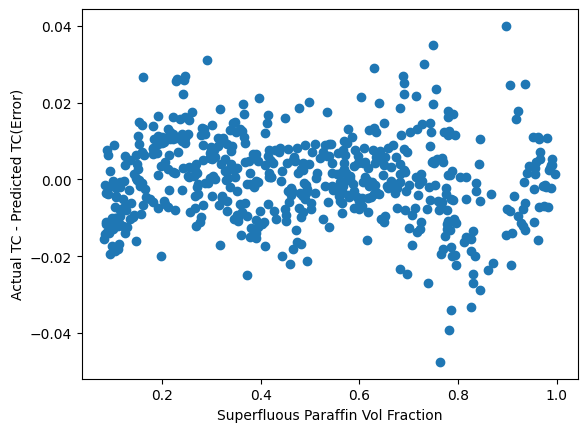

In [256]:
with torch.no_grad():
    actual=actual.to('cpu')
    pred=pred.to('cpu')
    superfluousVolPers=[torch.sum(x[0]).item()/(160*160) for x in test_dataset]
    plt.scatter(superfluousVolPers, (actual-pred))
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('Actual TC - Predicted TC(Error)')

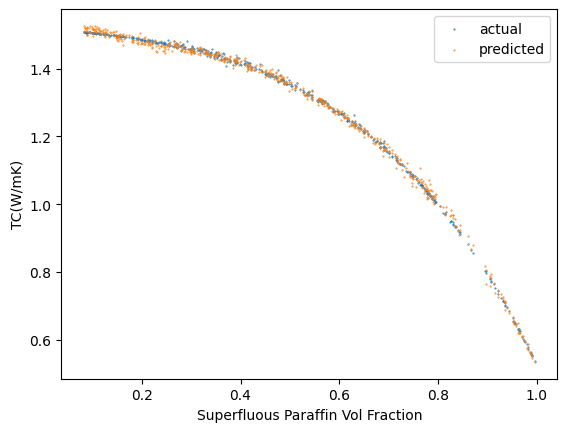

In [ ]:
with torch.no_grad():
    plt.scatter(superfluousVolPers, actual, label='actual', s=0.2)
    plt.scatter(superfluousVolPers, pred, label='predicted', s=0.2)
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    # ax=plt.gca()
    # ax.set_xlim([0, 0.8])
    # ax.set_ylim([1, 1.6])
    plt.legend()

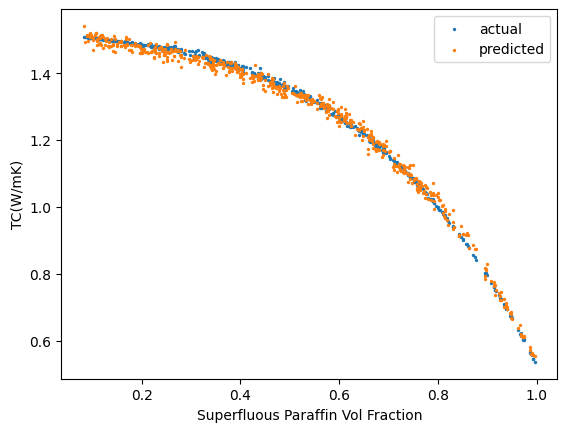

In [63]:
with torch.no_grad():
    plt.scatter(superfluousVolPers, actual, label='actual', s=2)
    plt.scatter(superfluousVolPers, pred, label='predicted', s=2)
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    # ax=plt.gca()
    # ax.set_xlim([0, 0.8])
    # ax.set_ylim([1, 1.6])
    plt.legend()

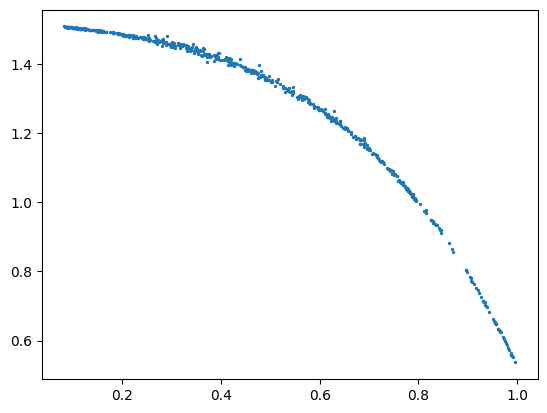

In [202]:
plt.scatter(superfluousVolPers, actual.to('cpu'), label='actual', s=2)

In [175]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.seq=nn.Sequential(
            nn.Linear(in_features=1, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x, vols):
        return self.seq(vols.unsqueeze(1))
    
mlp=BasicModel().to('cuda')

In [176]:
class BasicDataset(Dataset):
    def __init__(self, csv_path):
        with open(csv_path) as f:
            reader=csv.reader(f)
            d=list(reader)
        self.conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
        self.volPer=torch.tensor(data=[float(x[1]) for x in d[1:]], dtype=torch.float32)
    
    def __len__(self):
        return len(self.volPer)
    
    def __getitem__(self, index):
        return self.volPer[index], self.conductivities[index]
    
    def to(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)
basic_data=BasicDataset('./data/data.csv')
basic_train, basic_test=torch.utils.data.random_split(basic_data, [0.8, 0.2])
basic_data[0]

(tensor(0.7990), tensor(1.0010))

In [177]:
val_loss, train_loss=train_CNN(train_dataset, mlp, torch.nn.MSELoss(), torch.optim.Adam(mlp.parameters(), lr=0.001), 300)

0 TRAINING LOSS: 1.0632186166027136 VALIDATION LOSS: 0.8205918473733121
1 TRAINING LOSS: 0.4615488264121507 VALIDATION LOSS: 0.09997813706210026
2 TRAINING LOSS: 0.0449411088045229 VALIDATION LOSS: 0.03416354435567794
3 TRAINING LOSS: 0.018026570879380432 VALIDATION LOSS: 0.009493310938680048
4 TRAINING LOSS: 0.00487206132547407 VALIDATION LOSS: 0.0043795248380571845
5 TRAINING LOSS: 0.0026352283705164794 VALIDATION LOSS: 0.00269090361630159
6 TRAINING LOSS: 0.0015945775432332436 VALIDATION LOSS: 0.0017074095018726402
7 TRAINING LOSS: 0.0010112585926738877 VALIDATION LOSS: 0.0011139811731435715
8 TRAINING LOSS: 0.000668818531139231 VALIDATION LOSS: 0.0007485269889483456
9 TRAINING LOSS: 0.00043019210703246165 VALIDATION LOSS: 0.00048943046854403
10 TRAINING LOSS: 0.00027051938722204223 VALIDATION LOSS: 0.00031524189644640817
11 TRAINING LOSS: 0.00017949425040441973 VALIDATION LOSS: 0.00021290850375546628
12 TRAINING LOSS: 0.00012832795778593752 VALIDATION LOSS: 0.00015837252537702443
1

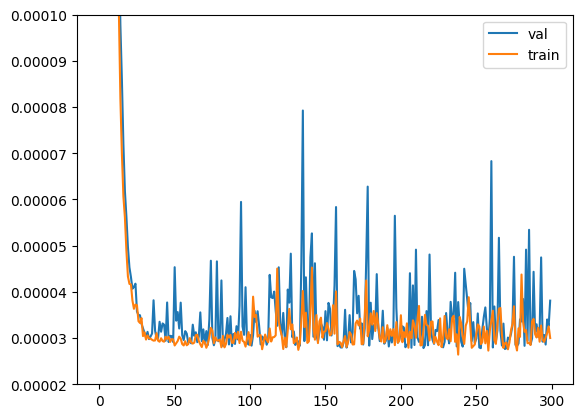

In [187]:
plt.plot(range(300), val_loss, label='val')
plt.plot(range(300), train_loss, label='train')
ax=plt.gca()
ax.set_ylim([0.00002,0.0001])
plt.legend()

340 567


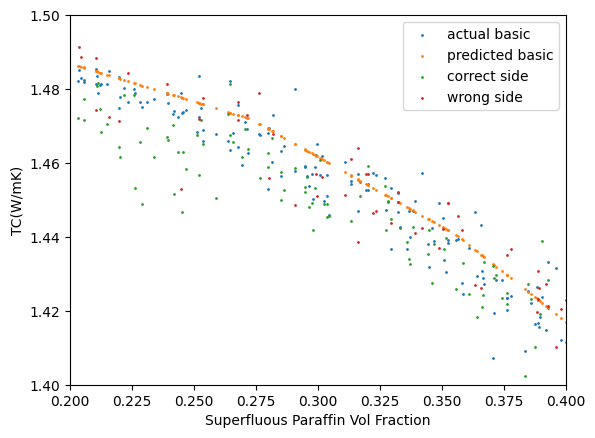

In [291]:
with torch.no_grad():
    pred_basic=mlp(test_dataset[:][0], test_dataset[:][1]).view(567).to('cpu')
    actual_basic=test_dataset[:][2].to('cpu')
    correctSide=[pred[i].item() if (pred_basic[i].item()-actual[i].item())*(pred_basic[i].item()-pred[i].item())>0 else 0 for i in range(len(actual))]
    wrongSide=[pred[i].item() if (pred_basic[i].item()-actual[i].item())*(pred_basic[i].item()-pred[i].item())<0 else 0 for i in range(len(actual))]
    plt.scatter(test_dataset[:][1].to('cpu'), actual_basic, label='actual basic', s=1)
    plt.scatter(test_dataset[:][1].to('cpu'), pred_basic, label='predicted basic', s=1)
    plt.scatter(test_dataset[:][1].to('cpu'), correctSide, label='correct side', s=1)
    plt.scatter(test_dataset[:][1].to('cpu'), wrongSide, label='wrong side', s=1)
    # plt.scatter(test_dataset[:][1].to('cpu'), pred.to('cpu'), label='predicted hybrid', s=1)
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    plt.legend()
    ax=plt.gca()
    ax.set_xlim([0.2, 0.4])
    ax.set_ylim([1.4, 1.5])
    print(sum([1 if (pred_basic[i].item()-actual[i].item())*(pred_basic[i].item()-pred[i].item())>0 else 0 for i in range(len(actual))]), len(actual))

In [268]:
for i in range(len(test_dataset)):
    print(actual[i].item(), pred[i].item(), pred_basic[i].item(), 'hybrid loss', actual[i].item()-pred[i].item(), 'basic loss', actual[i].item()-pred_basic[i].item())

1.257513403892517 1.2530790567398071 1.2640869617462158 hybrid loss 0.004434347152709961 basic loss -0.0065735578536987305
1.0594372749328613 1.065990924835205 1.0619345903396606 hybrid loss -0.00655364990234375 basic loss -0.0024973154067993164
1.4895583391189575 1.4731450080871582 1.4889198541641235 hybrid loss 0.016413331031799316 basic loss 0.0006384849548339844
1.0959504842758179 1.0978225469589233 1.100753664970398 hybrid loss -0.0018720626831054688 basic loss -0.004803180694580078
1.4151331186294556 1.4104413986206055 1.4069944620132446 hybrid loss 0.004691720008850098 basic loss 0.008138656616210938
1.4394958019256592 1.44578218460083 1.4402159452438354 hybrid loss -0.0062863826751708984 basic loss -0.0007201433181762695
1.4963685274124146 1.4820935726165771 1.4957987070083618 hybrid loss 0.014274954795837402 basic loss 0.0005698204040527344
1.5061955451965332 1.5177725553512573 1.5106133222579956 hybrid loss -0.011577010154724121 basic loss -0.004417777061462402
1.426486372947

(array([  2.,   2.,  12.,  50., 139., 178., 132.,  37.,  13.,   2.]),
 array([-0.0475055 , -0.03875673, -0.03000796, -0.02125919, -0.01251042,
        -0.00376165,  0.00498712,  0.01373589,  0.02248466,  0.03123343,
         0.0399822 ]),
 <BarContainer object of 10 artists>)

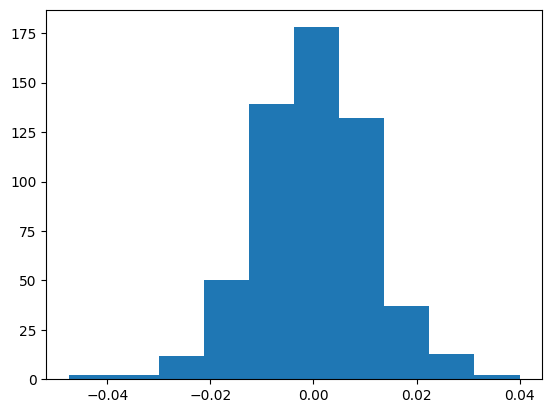

In [269]:
plt.hist(actual.to('cpu')-pred.to('cpu'))

(torch.Size([567]), torch.Size([567, 1]))

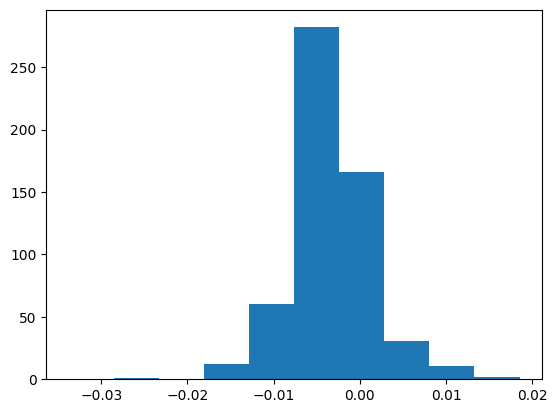

In [270]:
plt.hist(actual.to('cpu')-pred_basic.to('cpu').unsqueeze(1), bins=[-0.0337733 , -0.02854511, -0.02331691, -0.01808871, -0.01286051, -0.00763232, -0.00240412,  0.00282408,  0.00805228,  0.01328048, 0.01850867])
pred_basic.shape, pred.shape

In [271]:
print(actual.device, pred.device, pred_basic.device)
torch.sum(torch.abs(actual-pred)<torch.abs(actual-pred_basic.unsqueeze(1)))

cpu cpu cpu


tensor(183)

In [273]:
nn.SmoothL1Loss()(actual, pred), nn.SmoothL1Loss()(actual, pred_basic.unsqueeze(1))

(tensor(6.2831e-05), tensor(1.7101e-05))